In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.special import gamma

from ape import accounts, chain, Contract, networks, project

In [3]:
# SEE: https://gist.github.com/banteg/dcf6082ff7fc6ad51ce220146f29d9ff
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [4]:
# USDC/WETH 5bps pool, 8h candles
FILEPATH = "data/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400.csv"

In [5]:
# TODO: pull from contract
X_DECIMALS = 6
Y_DECIMALS = 18

In [6]:
df = pd.read_csv(FILEPATH)
df

,block_number,sqrt_price_x96
0,12509859,1488666029357725662978369934166891
1,12512259,1498758880028447235204616864140268
2,12514659,1527428496431482073729729059235451
3,12517059,1480447266659661332123963148536664
4,12519459,1510557878125983516937970465170106
...,...,...
2185,17753859,1829209344494308734880463990390144
2186,17756259,1830429610097533257794674119254826
2187,17758659,1827296619717806012513766568630551
2188,17761059,1831453713649288095012480151677960


In [7]:
# calculate prices for both y/x and x/y in case of "weird" token0, token1 ordering
def price(sqrt_price_x96) -> int:
    return (int(sqrt_price_x96) ** 2) // (1 << 192)

In [8]:
df['y/x'] = df['sqrt_price_x96'].apply(price)

In [9]:
df['x/y'] = 10 ** Y_DECIMALS // df['y/x']

In [10]:
df

,block_number,sqrt_price_x96,y/x,x/y
0,12509859,1488666029357725662978369934166891,353049327,2832465390
1,12512259,1498758880028447235204616864140268,357852759,2794445410
2,12514659,1527428496431482073729729059235451,371674366,2690527223
3,12517059,1480447266659661332123963148536664,349161795,2864001773
4,12519459,1510557878125983516937970465170106,363509339,2750960959
...,...,...,...,...
2185,17753859,1829209344494308734880463990390144,533049640,1875997890
2186,17756259,1830429610097533257794674119254826,533761072,1873497436
2187,17758659,1827296619717806012513766568630551,531935450,1879927348
2188,17761059,1831453713649288095012480151677960,534358505,1871402795


<Axes: xlabel='block_number'>

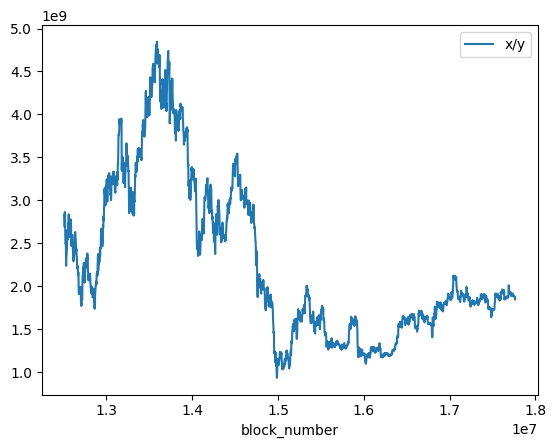

In [11]:
df.plot(x='block_number', y='x/y')

In [12]:
# calculate log differences for easier probability calcs. should have dlog(y/x) = -dlog(x/y)
df['dlog(y/x)'] = np.log(df['y/x']).diff()
df['dlog(x/y)'] = np.log(df['x/y']).diff()

In [13]:
df

,block_number,sqrt_price_x96,y/x,x/y,dlog(y/x),dlog(x/y)
0,12509859,1488666029357725662978369934166891,353049327,2832465390,NaN,NaN
1,12512259,1498758880028447235204616864140268,357852759,2794445410,0.013514,-0.013514
2,12514659,1527428496431482073729729059235451,371674366,2690527223,0.037896,-0.037896
3,12517059,1480447266659661332123963148536664,349161795,2864001773,-0.062483,0.062483
4,12519459,1510557878125983516937970465170106,363509339,2750960959,0.040270,-0.040270
...,...,...,...,...,...,...
2185,17753859,1829209344494308734880463990390144,533049640,1875997890,0.006022,-0.006022
2186,17756259,1830429610097533257794674119254826,533761072,1873497436,0.001334,-0.001334
2187,17758659,1827296619717806012513766568630551,531935450,1879927348,-0.003426,0.003426
2188,17761059,1831453713649288095012480151677960,534358505,1871402795,0.004545,-0.004545


<Axes: xlabel='block_number'>

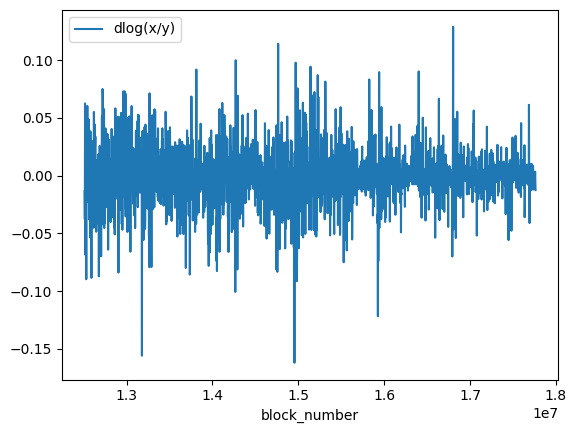

In [14]:
# plot log price diffs for x/y
df.plot(x='block_number', y='dlog(x/y)')

<Axes: ylabel='Frequency'>

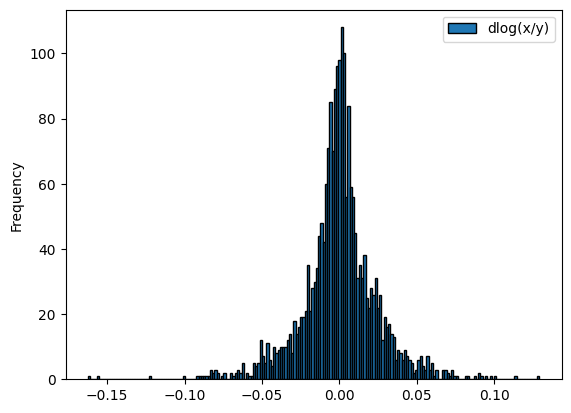

In [15]:
# histogram of log price diffs for x/y
df.plot(y='dlog(x/y)', kind='hist', bins=200, edgecolor='k')

In [16]:
# function to fit log price diffs to a few distributions
# SEE: https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python
def plot_fit_hist(df_data: pd.DataFrame, col: str, dists: list) -> dict:
    """
    Plots fits on top of histogram data. Returns fits for all dist names
    """
    params_data = {}

    df_data_col_notnull = df_data[df_data[col].notnull()][col]
    size = df_data_col_notnull.count()
    x = np.arange(-size // 2, size // 2 + 1, 1) / size
    x_lim_max = 1.1 * np.max([df_data_col_notnull.max(), np.abs(df_data_col_notnull.min())])
    
    ax = df_data.plot(y=col, kind='hist', bins=200, color='w', edgecolor='black', density=True, xlim=(-x_lim_max, x_lim_max))
    for dist in dists:
        params = getattr(stats, dist).fit(df_data_col_notnull)
        arg = params[:-2]
        pdf = getattr(stats, dist).pdf(x, *arg, loc=params[-2], scale=params[-1])
        df_pdf = pd.DataFrame(data={dist: pdf}, index=x)
        df_pdf.plot(ax=ax)
    
        # store param fits for later use in cell below
        params_data[dist] = [*params] + [None for _ in range(4 - len(params))]
    
    return params_data

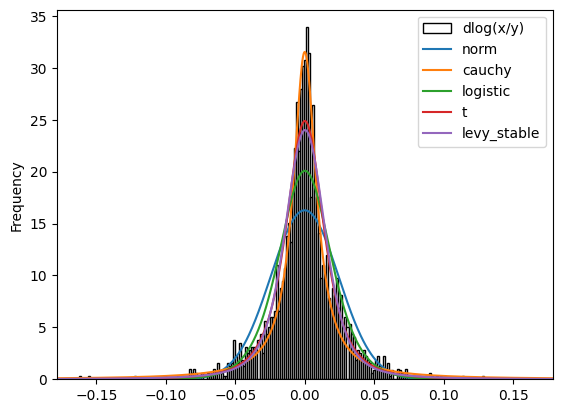

In [17]:
%%capture --no-display

params_data_8h = plot_fit_hist(df, 'dlog(x/y)', ['norm', 'cauchy', 'logistic', 't', 'levy_stable'])

In [18]:
# fit params to log price diffs on 8h candles
pd.DataFrame(data=params_data_8h).T

,0,1,2,3
norm,-0.000195,0.024509,NaN,NaN
cauchy,-0.000122,0.010093,NaN,NaN
logistic,-0.000002,0.012449,NaN,NaN
t,2.503150,0.000007,0.014541,NaN
levy_stable,1.461684,-0.006489,0.000009,0.012009


In [19]:
# combine candles to 24h to check time dependence approx scales as expected
df_24h = df.copy()
del df_24h['dlog(y/x)']
del df_24h['dlog(x/y)']

In [20]:
dn = df['block_number'][1] - df['block_number'][0]
dn

2400

In [21]:
df_24h = df_24h[((df_24h['block_number'] - df_24h['block_number'][0]) % (3 * dn)) == 0]
df_24h['dlog(y/x)'] = np.log(df_24h['y/x']).diff()
df_24h['dlog(x/y)'] = np.log(df_24h['x/y']).diff()

In [22]:
df_24h

,block_number,sqrt_price_x96,y/x,x/y,dlog(y/x),dlog(x/y)
0,12509859,1488666029357725662978369934166891,353049327,2832465390,NaN,NaN
3,12517059,1480447266659661332123963148536664,349161795,2864001773,-0.011072,0.011072
6,12524259,1585501632264840651461398646757001,400473902,2497041617,0.137113,-0.137113
9,12531459,1674767595764110141430162356094226,446837827,2237948400,0.109547,-0.109547
12,12538659,1620366257605301594604235198780872,418280110,2390742414,-0.066044,0.066044
...,...,...,...,...,...,...
2175,17729859,1823893365015002720368556956085828,529955885,1886949514,0.004709,-0.004709
2178,17737059,1821159497247585000963325973863758,528368354,1892619026,-0.003000,0.003000
2181,17744259,1820853069001439011437357276224749,528190562,1893256093,-0.000337,0.000337
2184,17751459,1823709489675585132013930704437651,529849035,1887330039,0.003135,-0.003135


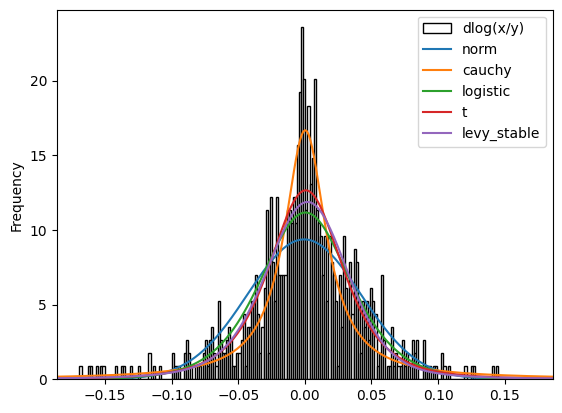

In [23]:
%%capture --no-display

params_data_24h = plot_fit_hist(df_24h, 'dlog(x/y)', ['norm', 'cauchy', 'logistic', 't', 'levy_stable'])

In [24]:
# fit params to log price diffs on 24h candles
pd.DataFrame(data=params_data_24h).T

,0,1,2,3
norm,-0.000562,0.042600,NaN,NaN
cauchy,0.000230,0.019085,NaN,NaN
logistic,0.000377,0.022392,NaN,NaN
t,3.271692,0.000642,0.029243,NaN
levy_stable,1.626879,-0.120572,-0.000356,0.023992


In [25]:
# fit params to log price diffs on 8h candles (again)
pd.DataFrame(data=params_data_8h).T

,0,1,2,3
norm,-0.000195,0.024509,NaN,NaN
cauchy,-0.000122,0.010093,NaN,NaN
logistic,-0.000002,0.012449,NaN,NaN
t,2.503150,0.000007,0.014541,NaN
levy_stable,1.461684,-0.006489,0.000009,0.012009


In [26]:
# should have scale parameter for levy stable family (norm, cauchy, levy_stable)
# change by sigma * (n) ** (1 / alpha) where n is number of candles in compressed dataset
#  ... e.g. norm: alpha=2, n=3 for 24h candles; cauchy: alpha=1, n=3 for 24h candles
print("rel error for time scaling on norm (24h / 8h):", (params_data_24h['norm'][1] / params_data_8h['norm'][1]) / np.sqrt(3) - 1)
print("rel error for time scaling on cauchy (24h / 8h):", (params_data_24h['cauchy'][1] / params_data_8h['cauchy'][1]) / 3 - 1)
print("rel error for time scaling on stable w alpha 8h (24h / 8h):", (params_data_24h['levy_stable'][-1] / params_data_8h['levy_stable'][-1]) / 3 ** (1 / params_data_8h['levy_stable'][0]) - 1)
print("rel error for time scaling on stable w alpha 24h (24h / 8h):", (params_data_24h['levy_stable'][-1] / params_data_8h['levy_stable'][-1]) / 3 ** (1 / params_data_24h['levy_stable'][0]) - 1)

rel error for time scaling on norm (24h / 8h): 0.0035144690953239355
rel error for time scaling on cauchy (24h / 8h): -0.3696943434572205
rel error for time scaling on stable w alpha 8h (24h / 8h): -0.05778359304814751
rel error for time scaling on stable w alpha 24h (24h / 8h): 0.016940659888136755


In [27]:
print("rel error for levy stable tail param (24h / 8h):", params_data_24h['levy_stable'][0] / params_data_8h['levy_stable'][0] - 1)

rel error for levy stable tail param (24h / 8h): 0.11301700843767071


In [28]:
# save fit params for 8h to csv
OUTPATH = "fits/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400.csv"
df_params = pd.DataFrame(data=params_data_8h).T
df_params.to_csv(OUTPATH)

In [29]:
# optimal tick width calcs with period slider for various fits
def delta_c(alpha: float, sigma: float, tau: float) -> float:
    num = 6
    denom = (8 / (sigma * (tau ** (1/alpha))) ** 2) * (gamma(3/alpha) / gamma(1/alpha)) - 1
    return num / denom

def error_fn(alpha: float, sigma: float, tau: float, delta: float) -> float:
    z = delta / (sigma * (tau ** (1/alpha)))
    return stats.levy_stable.cdf(z, alpha, 0) - stats.levy_stable.cdf(-z, alpha, 0)

def g(alpha: float, sigma: float, tau: float, delta: float) -> float:
    return error_fn(alpha, sigma, tau, delta) / (1 - np.exp(-delta/2))

In [30]:
print("delta_c from 8h for 1 week rebalances (norm):", delta_c(2, params_data_8h['norm'][1], 7*3))
print("delta_c from 8h for 2 week rebalances (norm):", delta_c(2, params_data_8h['norm'][1], 14*3))
print("delta_c from 8h for 1 week rebalances (stable):", delta_c(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3))
print("delta_c from 8h for 2 week rebalances (stable):", delta_c(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 14*3))

delta_c from 8h for 1 week rebalances (norm): 0.018981625152466357
delta_c from 8h for 2 week rebalances (norm): 0.03808373215964293
delta_c from 8h for 1 week rebalances (stable): 0.009030457287145254
delta_c from 8h for 2 week rebalances (stable): 0.0233689743901478


In [31]:
print("error fn / prob liq active at delta c from 8h for 1 week rebalances (norm):", error_fn(2, params_data_8h['norm'][1], 7*3, delta_c(2, params_data_8h['norm'][1], 7*3)))
print("error fn / prob liq active at delta c from 8h for 2 week rebalances (norm):", error_fn(2, params_data_8h['norm'][1], 14*3, delta_c(2, params_data_8h['norm'][1], 14*3)))
print("error fn / prob liq active at delta c from 8h for 1 week rebalances (stable):", error_fn(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3, delta_c(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3)))
print("error fn / prob liq active at delta c from 8h for 2 week rebalances (stable):", error_fn(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 14*3, delta_c(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 14*3)))

error fn / prob liq active at delta c from 8h for 1 week rebalances (norm): 0.09512409654396131
error fn / prob liq active at delta c from 8h for 2 week rebalances (norm): 0.13462874611915954
error fn / prob liq active at delta c from 8h for 1 week rebalances (stable): 0.05395385378257189
error fn / prob liq active at delta c from 8h for 2 week rebalances (stable): 0.0867410037059897


In [32]:
# plot error fns and g for various deltas at 1 week rebalance with 8 hr candles
ds = np.arange(0.001, 0.0501, 0.001)

g_norm = g(2, params_data_8h['norm'][1], 7*3, ds)
err_norm = error_fn(2, params_data_8h['norm'][1], 7*3, ds)
delta_c_norm = delta_c(2, params_data_8h['norm'][1], 7*3)

g_stable = g(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3, ds)
err_stable = error_fn(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3, ds)
delta_c_stable = delta_c(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], 7*3)

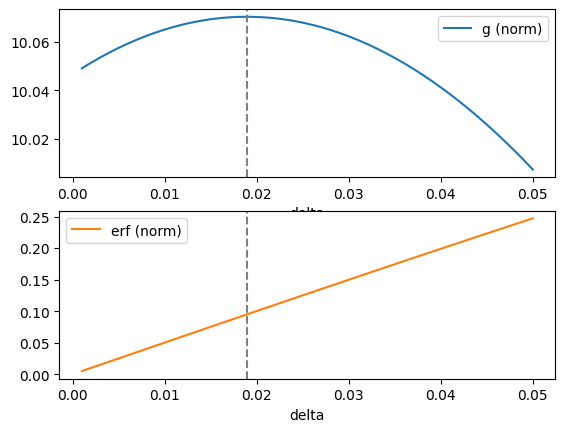

In [33]:
fig, ax = plt.subplots(2, 1)
df_lp_norm = pd.DataFrame({'delta': ds, 'g': g_norm, 'err': err_norm})

df_lp_norm.plot(x='delta', y='g', ax=ax[0], color='C0', label='g (norm)')
df_lp_norm.plot(x='delta', y='err', ax=ax[1], color='C1', label='erf (norm)')

ax[0].axvline(delta_c_norm, color='C7', linestyle='--', label='delta c (norm)')
ax[1].axvline(delta_c_norm, color='C7', linestyle='--', label='delta c (norm)')

fig.savefig("assets/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400_g_v_delta_norm.png")

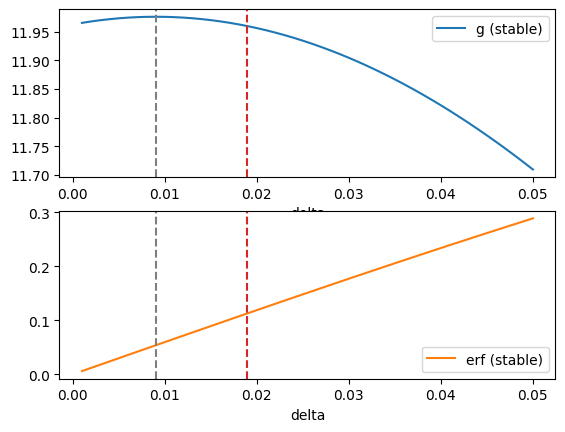

In [34]:
fig, ax = plt.subplots(2, 1)
df_lp_stable = pd.DataFrame({'delta': ds, 'g': g_stable, 'err': err_stable})

df_lp_stable.plot(x='delta', y='g', ax=ax[0], color='C0', label='g (stable)')
df_lp_stable.plot(x='delta', y='err', ax=ax[1], color='C1', label='erf (stable)')

ax[0].axvline(delta_c_stable, color='C7', linestyle='--', label='delta c (stable)')
ax[1].axvline(delta_c_stable, color='C7', linestyle='--', label='delta c (stable)')

ax[0].axvline(delta_c_norm, color='C3', linestyle='--', label='delta c (norm)')
ax[1].axvline(delta_c_norm, color='C3', linestyle='--', label='delta c (norm)')

fig.savefig("assets/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400_g_v_delta_stable.png")

In [35]:
# plot error fns and g vs time since last rebalance for delta c calibrated at 1 week with 8 hr candles
ts = np.arange(0.125, 21.000, 0.125)

g_norm = g(2, params_data_8h['norm'][1], ts, delta_c_norm)
err_norm = error_fn(2, params_data_8h['norm'][1], ts, delta_c_norm)

g_stable = g(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], ts, delta_c_stable)
err_stable = error_fn(params_data_8h['levy_stable'][0], params_data_8h['levy_stable'][-1], ts, delta_c_stable)

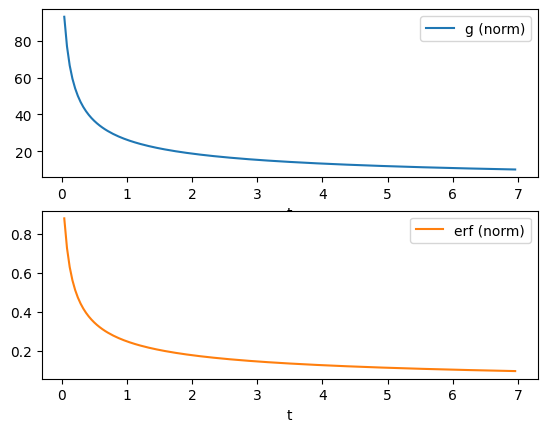

In [36]:
fig, ax = plt.subplots(2, 1)
df_lp_norm = pd.DataFrame({'t': ts / 3, 'g': g_norm, 'err': err_norm})

df_lp_norm.plot(x='t', y='g', ax=ax[0], color='C0', label='g (norm)')
df_lp_norm.plot(x='t', y='err', ax=ax[1], color='C1', label='erf (norm)')

fig.savefig("assets/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400_g_v_t_norm.png")

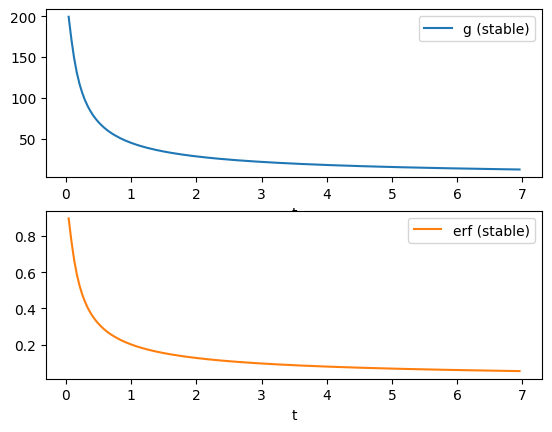

In [37]:
fig, ax = plt.subplots(2, 1)
df_lp_stable = pd.DataFrame({'t': ts / 3, 'g': g_stable, 'err': err_stable})

df_lp_stable.plot(x='t', y='g', ax=ax[0], color='C0', label='g (stable)')
df_lp_stable.plot(x='t', y='err', ax=ax[1], color='C1', label='erf (stable)')

fig.savefig("assets/price_0x88e6A0c2dDD26FEEb64F039a2c41296FcB3f5640_12509859_17765859_2400_g_v_t_stable.png")